In [155]:
import pandas as pd
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.metrics import *
import numpy as np
import matplotlib.pyplot as plt
import timeit
from contextlib import contextmanager

In [156]:
import warnings
warnings.filterwarnings('ignore')

In [157]:
df = pd.read_csv(
    "heart.csv"
)

df.dropna(inplace=True)

label_map = {"Yes": 0, "No": 1}
chestpain_map = {"typical": 0, "asymptomatic": 1, "nonanginal": 2, "nontypical" : 3}
thal_map = {"fixed": 0, "normal": 1, "reversable": 2}

df["AHD"] = df["AHD"].apply(lambda x: label_map[x])
df["ChestPain"] = df["ChestPain"].apply(lambda x: chestpain_map[x])
df["Thal"] = df["Thal"].apply(lambda x: thal_map[x])

df.head(10)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,0,145,233,1,2,150,0,2.3,3,0.0,0,1
1,67,1,1,160,286,0,2,108,1,1.5,2,3.0,1,0
2,67,1,1,120,229,0,2,129,1,2.6,2,2.0,2,0
3,37,1,2,130,250,0,0,187,0,3.5,3,0.0,1,1
4,41,0,3,130,204,0,2,172,0,1.4,1,0.0,1,1
5,56,1,3,120,236,0,0,178,0,0.8,1,0.0,1,1
6,62,0,1,140,268,0,2,160,0,3.6,3,2.0,1,0
7,57,0,1,120,354,0,0,163,1,0.6,1,0.0,1,1
8,63,1,1,130,254,0,2,147,0,1.4,2,1.0,2,0
9,53,1,1,140,203,1,2,155,1,3.1,3,0.0,2,0


In [158]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [159]:
# feature selection with f1 score
selector = SelectKBest(score_func=f_classif, k=10)
selector = selector.fit(X, y)
predictors = X.columns[selector.get_support()]

# extract the input variables and output variable
x  = df[predictors]

# split the data into 80% training and 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=42, stratify=y)

In [160]:
# create an empty dataframe to store the result
results_table = pd.DataFrame(columns=['Random Forest', 'Decision Tree', 'AdaBoost', 'Gaussian Naive Bayes', 'Logistic Regression', 'Stacking'])

# model wrapper function
def train_model(classifier, features, label):
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(classifier, features, label, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    return scores

# get an array of all algorithms
models = list()
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier())) 
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB())) 
models.append(('Logistic Regression', LogisticRegression(solver='saga')))

baselines = models.copy()

# building a stacking classifier
def SClassifier():
	model_1 = LogisticRegression()
	model = StackingClassifier(estimators=baselines, final_estimator=model_1)
	return model

models.append(('Stacking', SClassifier()))  

In [161]:
# create an empty lists for box chart
results, model_name = list(), list()

# evaluate the models
for name, model in models:
    evaluate = train_model(model, x_train, y_train)
    results.append(evaluate)
    model_name.append(name)
    results_table.loc['Imbalanced data I', name] = np.mean(evaluate)
    print("%s: %f (%f)" % (name, np.mean(evaluate), np.std(evaluate)))

Random Forest: 0.816154 (0.087193)
Decision Tree: 0.764755 (0.064721)
AdaBoost: 0.788619 (0.054358)
Gaussian Naive Bayes: 0.815321 (0.060913)
Logistic Regression: 0.731340 (0.053158)
Extreme Gradient Boost: 0.773800 (0.071120)
Stacking: 0.837104 (0.065413)


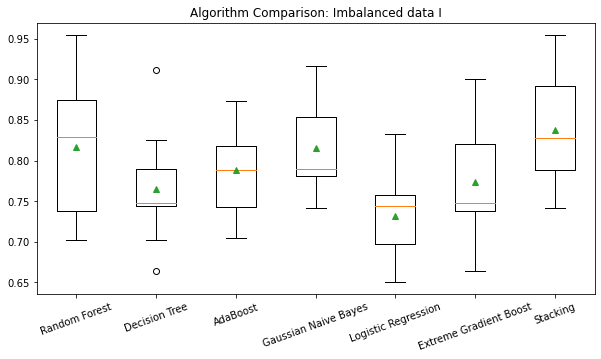

In [162]:
# to help with plotting Algorithms performance
def algorithm_plot(results, model_name, title):
    plt.figure (figsize =(10,5))
    plt.boxplot(results, labels=model_name, showmeans=True)
    plt.xticks(rotation=20)
    plt.title(title)
    plt.show()

# compare Algorithms performance
algorithm_plot(results, model_name, 'Algorithm Comparison: Imbalanced data I') 

# Fine tuning Hyperparameters

In [163]:
# stack all models
models_tune = [ DecisionTreeClassifier(),
            AdaBoostClassifier(),
            RandomForestClassifier(),
            GaussianNB(),
            LogisticRegression(solver='saga')]
          
names = ["DecisionTree","AdaBoostClassifier","RandomForest","GaussianNB","LogisticRegression"]

In [164]:
# possible hyper parameters
clf_params = {"criterion": ["gini", "entropy"],
               "min_samples_split" : list(range(2,6)),
               "max_depth": list(range(10,21))}

ada_params = {'n_estimators': [50,10,20,30]}

rf_params = {'n_estimators':[10,30],
                "max_depth": list(range(3,12))}

nb_params = {'var_smoothing': np.logspace(0,-9, num=10)}

logreg_params= {"C":np.logspace(-1, 1, 3),
                    "max_iter":[100, 1000]}

classifier_params = [clf_params, ada_params, rf_params, nb_params, logreg_params]

In [165]:
# create a timer
@contextmanager
def timer(title):
    start = timeit.default_timer()
    yield
    print("{} done in {:.0f}s".format(title, timeit.default_timer() - start))

# fine tune the model  
grid_result = {}
best_estimators = {}
for name, model, classifier_param in zip(names, models_tune, classifier_params):
    with timer("Model tuning"):
        clf = GridSearchCV(model, param_grid=classifier_param, scoring = "accuracy", n_jobs = -1,verbose = False)
        clf.fit(x_train,y_train)
        grid_result[name]=clf.best_score_
        best_estimators[name]=clf.best_estimator_
        print(name,'accuracy : %.3f'%grid_result[name])

DecisionTree accuracy : 0.772
Model tuning done in 5s
AdaBoostClassifier accuracy : 0.818
Model tuning done in 1s
RandomForest accuracy : 0.836
Model tuning done in 3s
GaussianNB accuracy : 0.827
Model tuning done in 0s
LogisticRegression accuracy : 0.811
Model tuning done in 1s


In [166]:
# model wrapper function
def train_model(classifier, features, label):
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(classifier, features, label, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    return scores

# get an array of all algorithms
models = list()
models.append(('Random Forest', best_estimators['RandomForest']))
models.append(('Decision Tree', best_estimators['DecisionTree'])) 
models.append(('AdaBoost', best_estimators['AdaBoostClassifier']))
models.append(('Gaussian Naive Bayes', best_estimators['GaussianNB'])) 
models.append(('Logistic Regression', best_estimators['LogisticRegression']))

baselines = models.copy()

# building a stacking classifier
def SClassifier():
	model_1 = LogisticRegression()
	model = StackingClassifier(estimators=baselines, final_estimator=model_1)
	return model

models.append(('Stacking', SClassifier()))  

In [167]:
# create an empty lists for box chart
results, model_name = list(), list()

# evaluate the models
for name, model in models:
    evaluate = train_model(model, x_train, y_train)
    results.append(evaluate)
    model_name.append(name)
    results_table.loc['Best Model', name] = np.mean(evaluate)
    print("%s: %f (%f)" % (name, np.mean(evaluate), np.std(evaluate)))

Random Forest: 0.792378 (0.077950)
Decision Tree: 0.734015 (0.064599)
AdaBoost: 0.806480 (0.081388)
Gaussian Naive Bayes: 0.819167 (0.057218)
Logistic Regression: 0.814563 (0.093298)
Stacking: 0.823788 (0.074010)


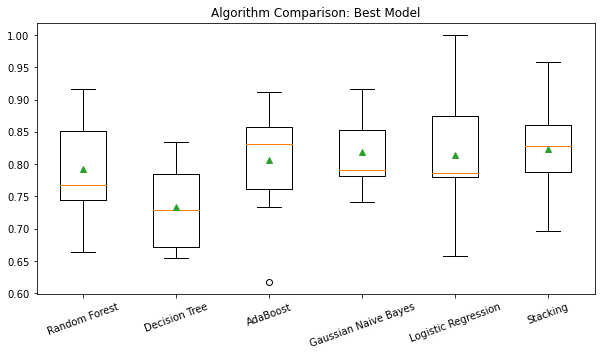

In [168]:
# compare Algorithms performance
algorithm_plot(results, model_name, 'Algorithm Comparison: Best Model') 

In [169]:
results_table

,Random Forest,Decision Tree,AdaBoost,Gaussian Naive Bayes,Logistic Regression,Extreme Gradient Boost,Stacking
Imbalanced data I,0.816154,0.764755,0.788619,0.815321,0.73134,0.7738,0.837104
Best Model,0.792378,0.734015,0.80648,0.819167,0.814563,NaN,0.823788


In [170]:
clf = SClassifier()
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

In [171]:
import pickle 

# save the model to disk
filename = 'heart_model.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.7833333333333333
